In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
#Read NO-NO2-NOx Series
dataFrame = pd.read_excel("../data/DataAirTrain.xlsx",index_col= 'time', sheet_name="PM1-PM2_5-PM10-TSP")
dataFrame = dataFrame.tail(1000)

In [3]:
dataFrame = dataFrame.interpolate(method='linear')

In [4]:
#Fix gap in time index
dataFrame = dataFrame.resample('H').interpolate(method='linear')

In [5]:
from statsmodels.tsa.stattools import adfuller
def stationary(var, desc):
    print(
        f"'{desc}' is stationary: "
        f"{adfuller(var)[0] < adfuller(var)[4]['1%']}.")
stationary(dataFrame[['PM-1']], 'PM-1')
stationary(dataFrame[['PM-2-5']], 'PM-2-5')
stationary(dataFrame[['PM-10']], 'PM-10')
stationary(dataFrame[['TSP']], 'TSP')

'PM-1' is stationary: True.
'PM-2-5' is stationary: True.
'PM-10' is stationary: True.
'TSP' is stationary: True.


In [6]:
trainSet = dataFrame[: -48]
testSet = dataFrame[-48: ]
dataFrameCopy = dataFrame
dataFrame = trainSet

In [7]:
from statsmodels.tsa.api import VAR
model = VAR(dataFrame)

In [8]:
sorted_order = model.select_order(24)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        8.539       8.560       5112.       8.547
1        5.280       5.384       196.5       5.320
2        5.136       5.322       170.1       5.207
3        4.896      5.164*       133.7      4.998*
4        4.903       5.254       134.7       5.037
5        4.908       5.341       135.4       5.073
6        4.918       5.434       136.7       5.115
7        4.900       5.498       134.2       5.127
8        4.886       5.567       132.5       5.146
9        4.859       5.622       128.9       5.150
10       4.832       5.677       125.4       5.154
11       4.844       5.771       127.0       5.197
12      4.796*       5.807      121.1*       5.181
13       4.801       5.894       121.7       5.217
14       4.825       6.001       124.7       5.273
15       4.841       6.099       126.7       5.320
16       4.845       6.185     

In [9]:
lag = sorted_order.aic
results = model.fit(lag)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 12, Mar, 2023
Time:                     00:01:42
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    5.76516
Nobs:                     952.000    HQIC:                   5.14595
Log likelihood:          -7475.39    FPE:                    117.358
AIC:                      4.76486    Det(Omega_mle):         96.0115
--------------------------------------------------------------------
Results for equation PM-1
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.334213         0.155256            2.153           0.031
L1.PM-1            0.617523         0.153799            4.015           0.000
L1.PM-2-5          0.181161         0.104948            1.726           0

<AxesSubplot:title={'center':'Test Set'}, xlabel='time'>

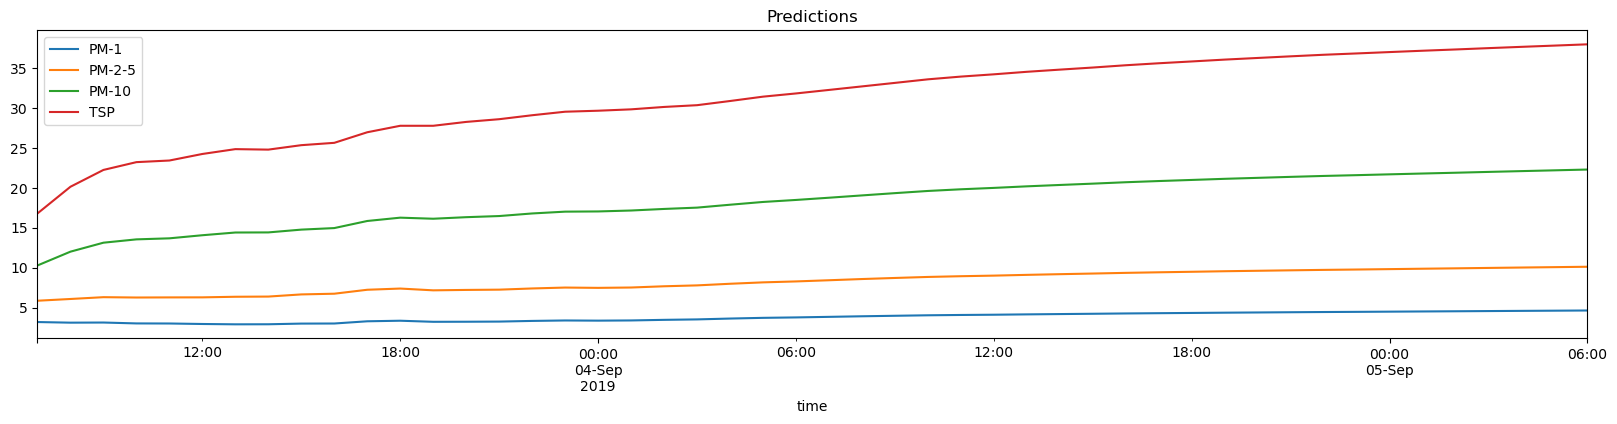

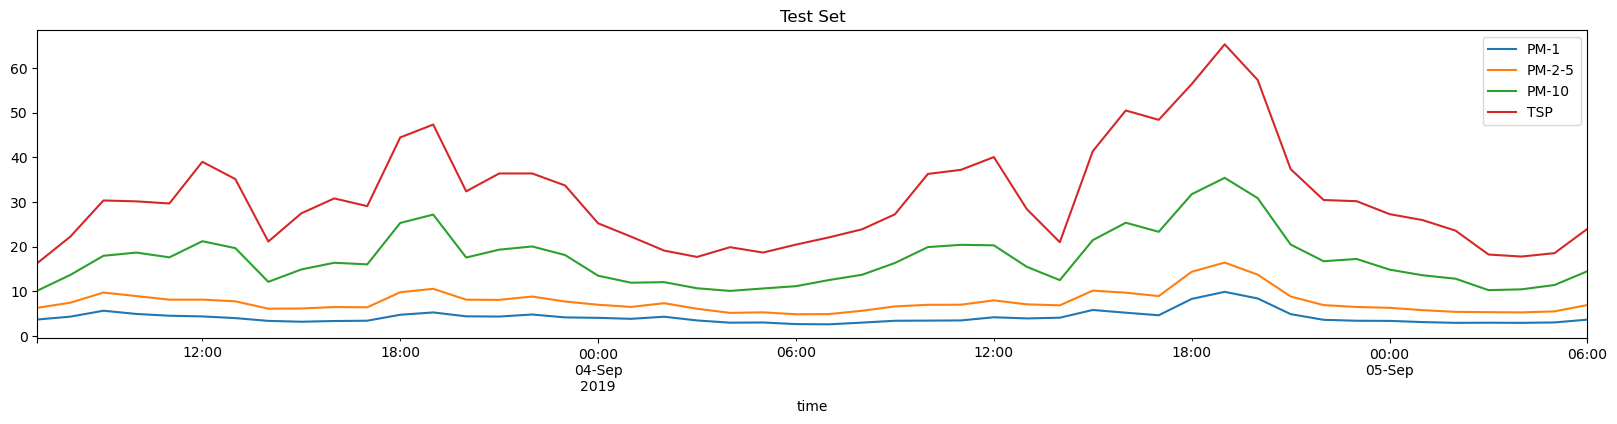

In [10]:
step = 48
dateTimeIndex = pd.date_range(dataFrame.index[-1] + pd.DateOffset(hours=1), periods=step, freq="H")
idx = pd.Index(dateTimeIndex, name='time')
predictions = results.forecast(dataFrame.values[-lag :], steps = step)
dataFramePredicted = pd.DataFrame(predictions, index=idx, columns=dataFrame.columns.values)

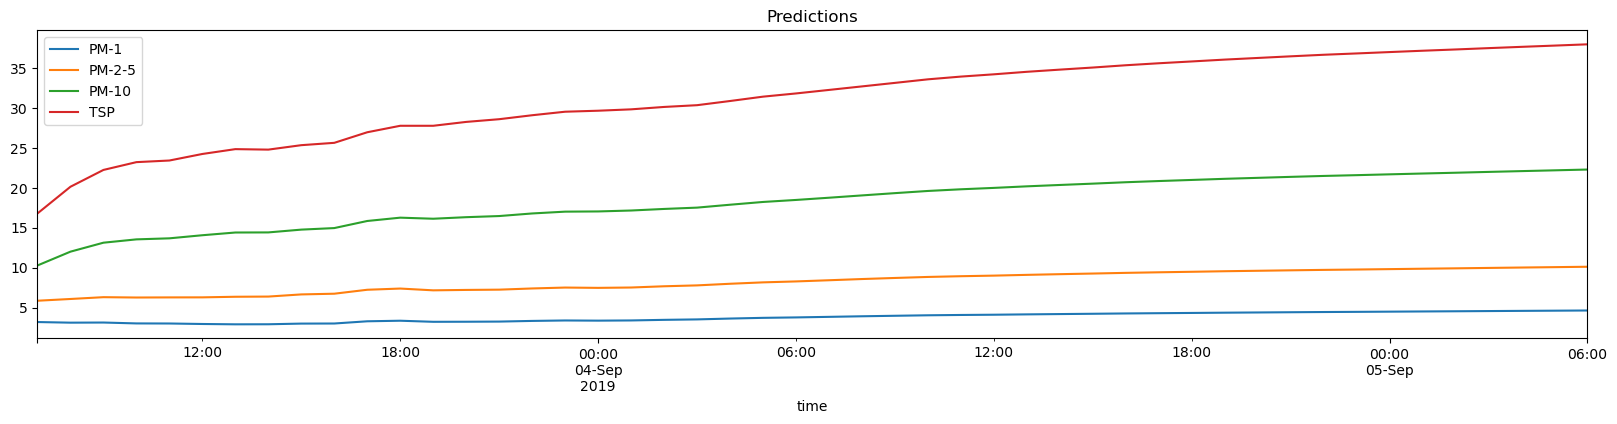

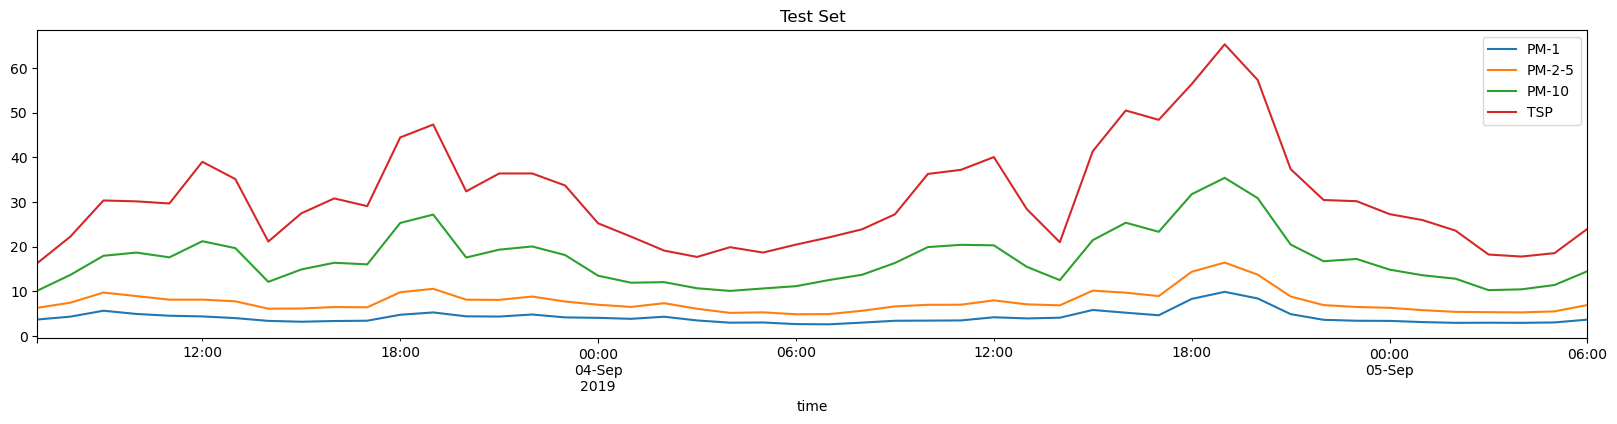

In [11]:
predictPMFig = dataFramePredicted.plot(figsize=(20,4), title='Predictions')
testFig = testSet.plot(figsize=(20,4), title='Test Set')
figure = predictPMFig.get_figure()    
figure.savefig(f'../figure/predictPMFig.png',bbox_inches ="tight")
figure = testFig.get_figure()    
figure.savefig(f'../figure/testPMFig.png',bbox_inches ="tight")

In [12]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})
tmp = []
tmp.append(forecast_accuracy(dataFramePredicted.iloc[:,0], testSet.iloc[:,0]))
tmp.append(forecast_accuracy(dataFramePredicted.iloc[:,1], testSet.iloc[:,1]))
tmp.append(forecast_accuracy(dataFramePredicted.iloc[:,2], testSet.iloc[:,2]))
tmp.append(forecast_accuracy(dataFramePredicted.iloc[:,3], testSet.iloc[:,3]))
metric = pd.DataFrame(tmp,index=dataFramePredicted.columns.values)
print(metric)

            mape        me       mae       mpe       rmse      corr    minmax
PM-1    0.265234 -0.418281  1.183571 -0.020612   1.573623  0.068200  0.231801
PM-2-5  0.318032  0.604096  2.250052  0.163828   2.735337  0.044306  0.233278
PM-10   0.342004  0.969150  5.235994  0.164585   6.380579  0.121090  0.244047
TSP     0.348964  0.078989  9.890300  0.120779  11.709208  0.165744  0.259992


C:\Users\admin\AppData\Local\Temp\ipykernel_1400\869266735.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:,None],
C:\Users\admin\AppData\Local\Temp\ipykernel_1400\869266735.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\admin\AppData\Local\Temp\ipykernel_1400\869266735.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:,None],
C:\Users\admin\AppData\Local\Temp\ipykernel_1400\869266735.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, Non